In [4]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

from sklearn.metrics import auc
import xgboost as xgb


from sklearn.model_selection import train_test_split

import os

In [5]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/criteo-uplift-sample.csv
data/criteo-uplift.csv


In [6]:
df=pd.read_csv('data/criteo-uplift.csv')

查看数据集信息

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


#### 数据集信息
1.数据条数：13979592\
2.feature:12个\
3.占用内存：1.7GB

In [8]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [9]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


In [10]:
df['treatment'].value_counts(normalize=True) #查看归一化后的比例
# df['treatment'].value_counts() # 查看实际条数

treatment
1    0.85
0    0.15
Name: proportion, dtype: float64

## Basic Eda

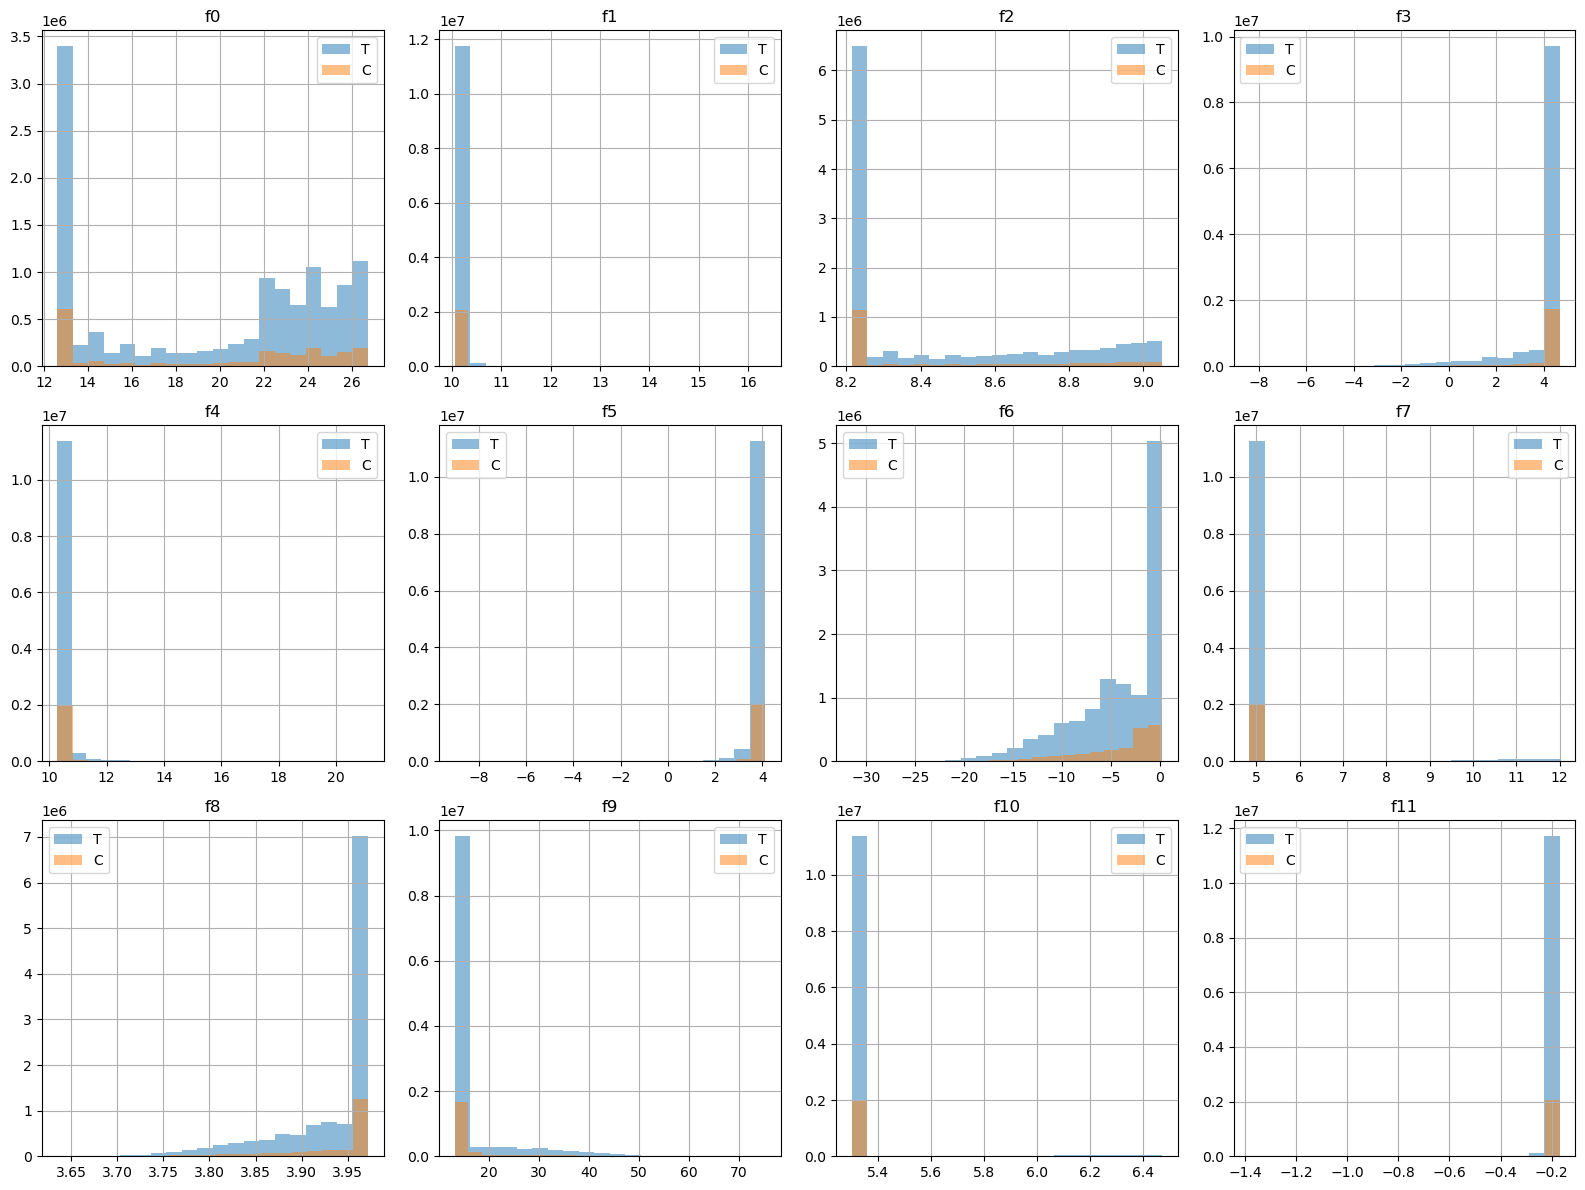

In [11]:
features = [f'f{i}' for i in range(0, 12)]

# 选几个代表性特征，画 T/C 组分布对比
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    # 如果是类别型（unique < 50），用 countplot；否则用 hist
    if df[feat].nunique() < 50:
        sns.countplot(data=df, x=feat, hue='treatment', ax=ax)
    else:
        df[df['treatment']==1][feat].hist(alpha=0.5, label='T', bins=20, ax=ax)
        df[df['treatment']==0][feat].hist(alpha=0.5, label='C', bins=20, ax=ax)
        ax.legend()
    ax.set_title(feat)

plt.tight_layout()
plt.savefig("figures/feature_balance.png", dpi=150)
plt.show()

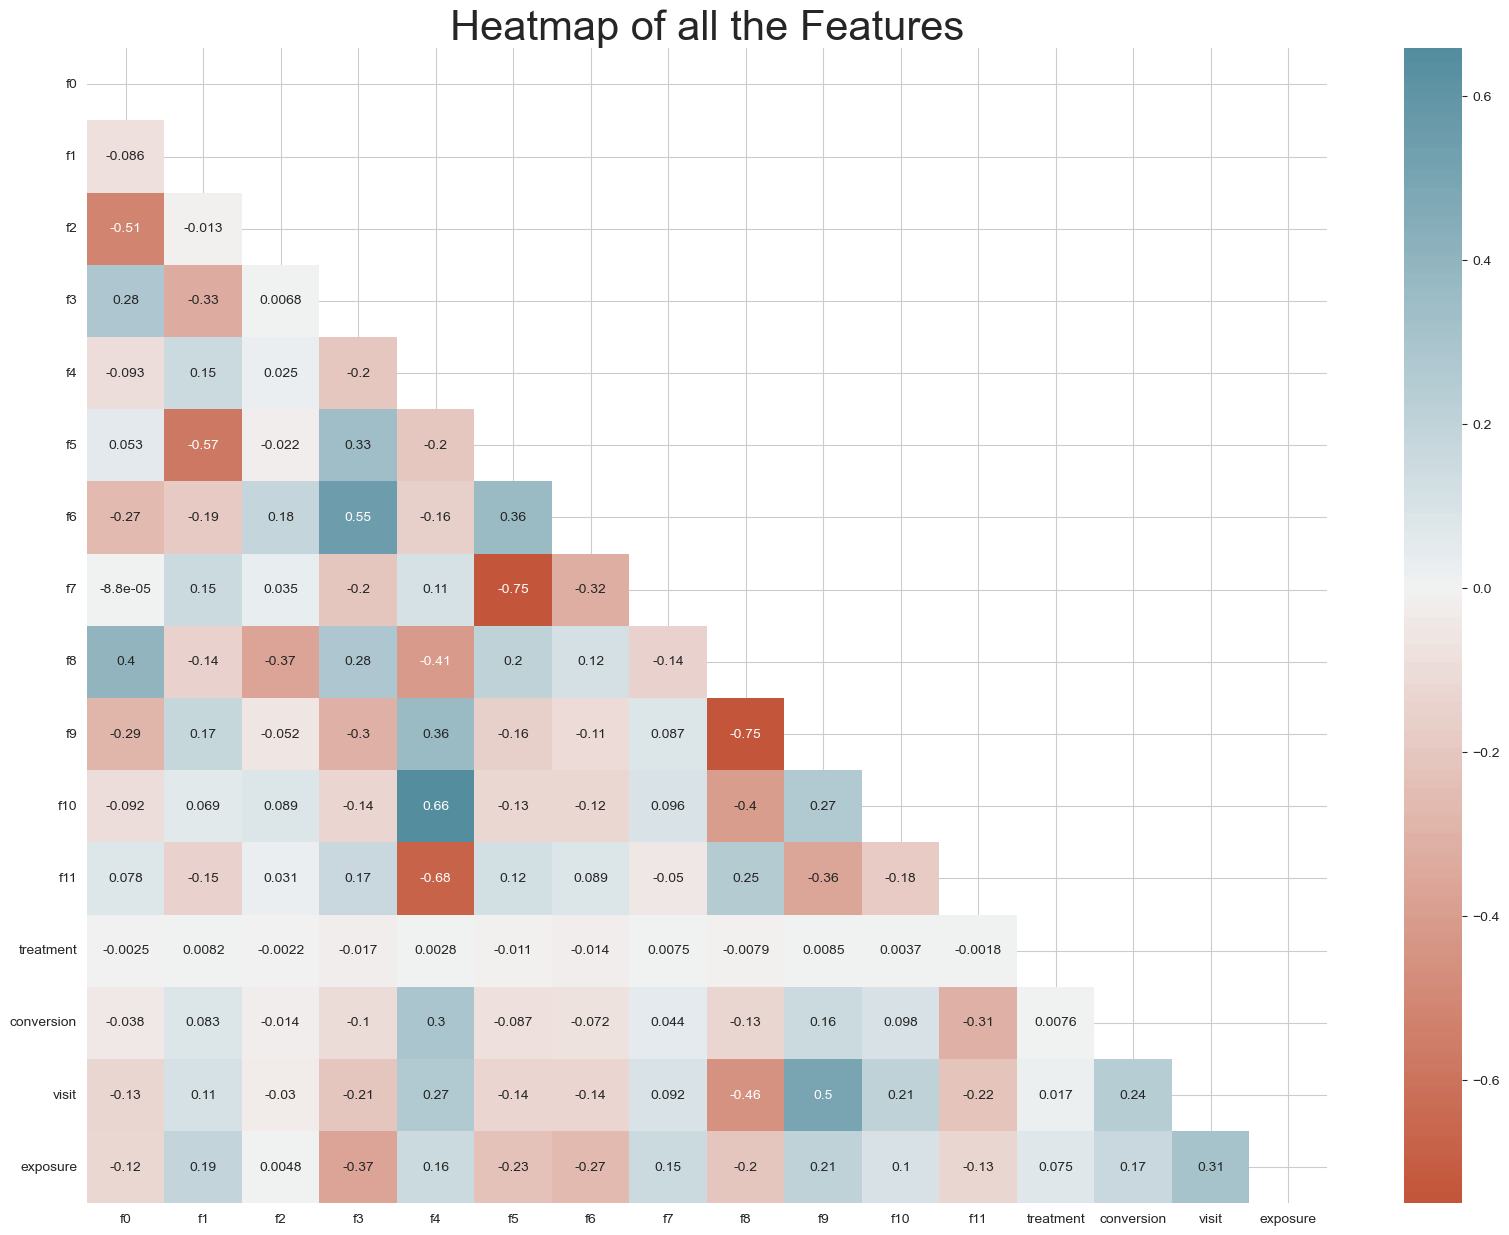

In [12]:
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (20,15))
## 热力图

mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(df.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0, )
plt.title("Heatmap of all the Features", fontsize = 30)
plt.yticks(rotation=0)
plt.savefig("figures/feature_heatmap.png", dpi=150)
plt.show()

1.conversion 与 f4 弱正相关（0.3）\
2.f10 和f4 强正相关(0.66)\
3.f5 和 f7 强负相关（-0.75）\
4.f8 和 f9 强负相关（-0.75）

In [13]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4))) #访问率
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4))) #转化率
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4))) #访问转化率

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


In [14]:
vis_results_df = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
vis_results_df

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [15]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [16]:
print(f'Difference in clickthrough rate between control and treatment: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between control and treatment: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between control and treatment: 0.0103
Difference in conversion between control and treatment: 0.0012


1.接受 Treate的用户访问率4.9% 高于对照组 3.8%，所以进行treate后能够有效促进用户访问，二者相差约1%\
2.接受treat的用户转化率 0.31%高于对照组0.19%\
3.转化率的差异并不明显，所以需要进行显著性检验

In [17]:
z_stat1, p_value1 =proportions_ztest(count=vis_results_df[('visit', 'sum')],
                  nobs=vis_results_df[('visit', 'count')])
print(f"p-value: {p_value1}")

p-value: 0.0


In [18]:
z_stat2, p_value2 =proportions_ztest(count=con_results_df[('conversion', 'sum')],
                  nobs=con_results_df[('conversion', 'count')])
print(f"p-value: {p_value2}")

p-value: 7.30826328583868e-179


1.treatment 对访问和转化都有高度显著的影响\
2.转化率的差异远大于访问率

值得一提的是，还有一个名为 exposure 的变量，用于指示用户是否确实被有效曝光于干预（treatment）之下。这一点很重要，因为即使被分配到处理组的用户，也可能在未实际受到干预影响的情况下执行了目标行为（如点击、购买等）。因此，考察用户是否被有效曝光是否会导致结果存在显著差异，将是一件很有意义的事情。

首先，处理组中有多少用户被实际曝光了？

In [19]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

exposure
0    0.963963
1    0.036037
Name: proportion, dtype: float64

In [20]:
df[df['treatment']==0]['exposure'].value_counts(normalize = True)

exposure
0    1.0
Name: proportion, dtype: float64

在我们的处理组中，仅有 3.6%（即每 28 名用户中约有 1 人）被有效曝光于干预，这表明该干预在吸引用户注意力方面效果非常差。

那么，在被处理的用户中，被有效曝光与未被有效曝光的用户在访问和转化人数上有什么差异？

In [21]:
vis_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'visit':['mean', 'sum', 'count']})
vis_exp_results_df

visit                  
              mean     sum     count
exposure                            
0         0.034861  399314  11454443
1         0.414538  177510    428212

In [22]:
con_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'conversion':['mean', 'sum', 'count']})
con_exp_results_df

conversion                 
               mean    sum     count
exposure                            
0          0.001194  13680  11454443
1          0.053784  23031    428212

In [23]:
proportions_ztest(count=vis_exp_results_df[('visit', 'sum')],
                  nobs=vis_exp_results_df[('visit', 'count')])[1]

np.float64(0.0)

In [24]:
proportions_ztest(count=con_exp_results_df[('conversion', 'sum')],
                  nobs=con_exp_results_df[('conversion', 'count')])[1]

np.float64(0.0)

被有效曝光的处理组用户点击率（41%）远高于未被曝光的处理组用户（3.5%）。转化率也呈现类似趋势：被曝光用户中有 5.3% 完成转化，而未被曝光的处理组用户仅有 0.12% 转化。这些结果结合极小的 p 值（<0.05）表明，该干预措施具有显著效果，但实际曝光的人数太少。\

接下来我们看看未被曝光是否对处理组产生了其他影响。

In [25]:
df[df['exposure']==0].groupby('treatment').agg({'visit':['mean', 'sum', 'count']})

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.034861  399314  11454443

In [26]:
df[df['exposure']==0].groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.001194  13680  11454443

从数据中可以发现，在处理组中，如果用户未被有效曝光，其访问和转化的比例实际上反而下降了，这意味着平均处理效应（ATE）为负。在现实场景中，这一问题需要加以解决。

# Resampling
在这种情况下， uplift 模型重点可以放在因未转化用户数量所带来的访问增量上（即访问了，但是未转化的用户）。在开始建模之前，有必要考虑数据集中是否存在任何不平衡，并相应地进行处理。

Class 0: 2096937
Class 1: 11882655
Proportion: 6 : 1


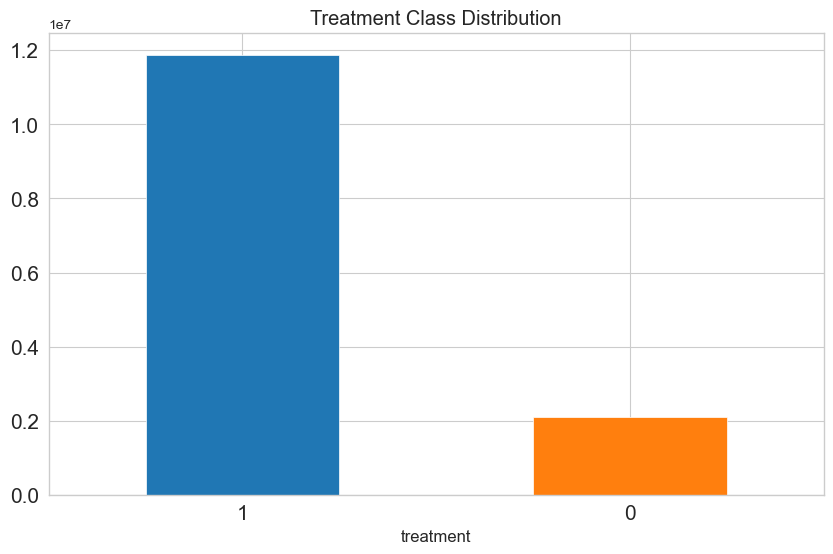

In [27]:
fig = plt.figure(figsize = (10,6))
target_count = df['treatment'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

通过观察分布，我们可以了解目标变量的偏斜程度——大多数用户都属于处理组。问题在于，许多 uplift 建模方法假设处理组和对照组的分布是平衡的，而这一假设在实践中未必成立。在这种情况下，我们可以对训练数据集进行重加权（reweighting）或重采样（resampling），使该假设成立。

根据 Jaśkowski 和 Jaroszewicz（2012）的研究，对处理组分布进行重采样可能会影响学习算法并导致信息损失；然而，只要算法能够较好地建模条件类别分布，所得结果仍然是有意义的。由于我们的数据集包含 1300 万行，可以相当确信任何重采样后的数据集仍包含足够多的样本，能够产生有意义的结果。

在进行随机欠采样（random undersampling）之前，我们必须将原始数据框拆分为训练集和测试集，仅对训练集进行欠采样。为什么？因为出于评估目的，我们希望在具有真实类别分布的数据集上测试模型性能。

In [28]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['treatment']) 
#确保训练集和测试集中treatment的分布一致

In [29]:
# 随机欠采样（找出多数类并对其减少采样）
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    #把数据更多的一类随机采样为少的一类一样多
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

In [30]:
train = random_under(train, 'treatment')

Class 0: 1677550
Class 1: 1677550
Proportion: 1 : 1


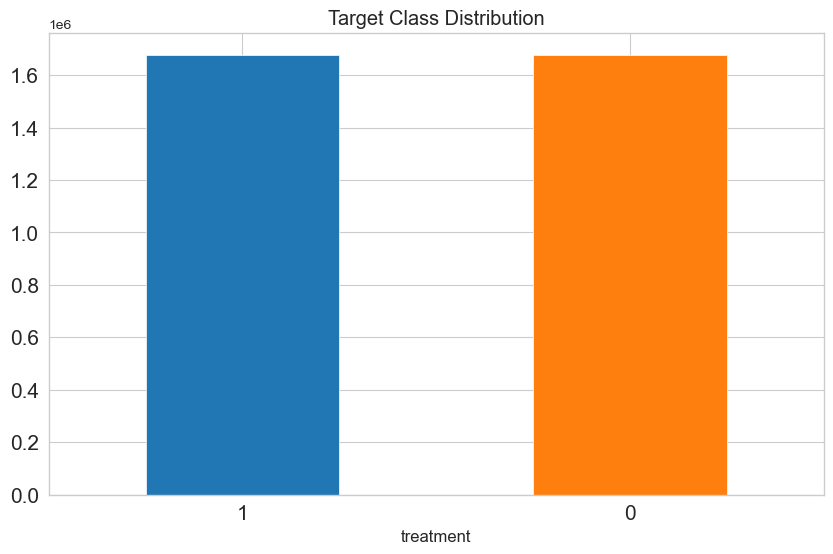

In [31]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['treatment'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

如上所示，新的训练数据集共有 3,355,100 个样本，其中处理组和对照组各占 50%。

# Uplift Modelling

本笔记本中使用的 uplift 模型是广义加权 uplift 模型（Generalized Weighted Uplift Model, LGWUM）（Kane 等，2014）。LGWUM 是 uplift 建模的多种方法之一，采用了一种被称为类别变量转换（Class Variable Transformation）的方法。
LGWUM 的基本假设是：正向 uplift 来自于对处理组响应者（TR），而应避免对处理组非响应者（TN）和对照组响应者（CR）进行干预。其形式化表达如下：

$$
\text{Uplift}_{\text{LGWUM}} = \frac{P(\text{TR})}{P(T)} + \frac{P(\text{CN})}{P(C)} - \frac{P(\text{TN})}{P(T)} - \frac{P(\text{CR})}{P(C)}
$$

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

In [32]:
# Target Class 定义
def target_class(df, treatment, target):
    #CN:对照组-不转化用户
    df['target_class'] = 0 
    #CR:对照组-转化用户
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:实验组-不转化用户
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:实验组-转化用户
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

In [33]:
train = target_class(train.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')
test = target_class(test.drop(columns = ['conversion', 'exposure']), 'treatment', 'visit')

In [34]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

该模型通过预测每个客户属于各个类别的概率来进行工作，然后可以通过这些概率之间的差异来计算 uplift。

In [36]:
def uplift_model(X_train,
                 X_test,
                 y_train,
                 y_test,
                 treatment_feature):

    result = pd.DataFrame(X_test).copy()    
    uplift_model = xgb.XGBClassifier().fit(X_train.drop(treatment_feature, axis=1), y_train)
    
    uplift_proba = uplift_model.predict_proba(X_test.drop(treatment_feature, axis=1))
    
    result['p_cn'] = uplift_proba[:,0] 
    result['p_cr'] = uplift_proba[:,1] 
    result['p_tn'] = uplift_proba[:,2] 
    result['p_tr'] = uplift_proba[:,3]
    
    result['uplift_score'] = result.eval('\
    p_cn/(p_cn + p_cr) \
    + p_tr/(p_tn + p_tr) \
    - p_tn/(p_tn + p_tr) \
    - p_cr/(p_cn + p_cr)')  

    # 合并结果数据
    result['target_class'] = y_test
    
    return result

In [37]:
result = uplift_model(X_train, X_test, y_train, y_test, 'treatment')
result.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,p_cn,p_cr,p_tn,p_tr,uplift_score,target_class
6304619,21.890358,10.059654,8.214383,4.679882,10.280525,4.115453,-4.595460,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.500800,0.000271,0.498652,0.000277,0.000027,0
4045638,15.995929,10.059654,8.214383,0.973841,10.280525,4.115453,-7.301017,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.503314,0.001629,0.493103,0.001954,0.001443,2
5767216,19.111923,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0.501900,0.000637,0.496571,0.000892,0.001052,0
9668584,12.870404,10.059654,8.979246,-1.025575,10.280525,4.115453,-16.175537,4.833815,3.902645,13.190056,5.300375,-0.168679,1,0.423548,0.010203,0.535389,0.030860,0.061950,2
830405,21.992620,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0.501184,0.000243,0.498354,0.000218,-0.000096,2


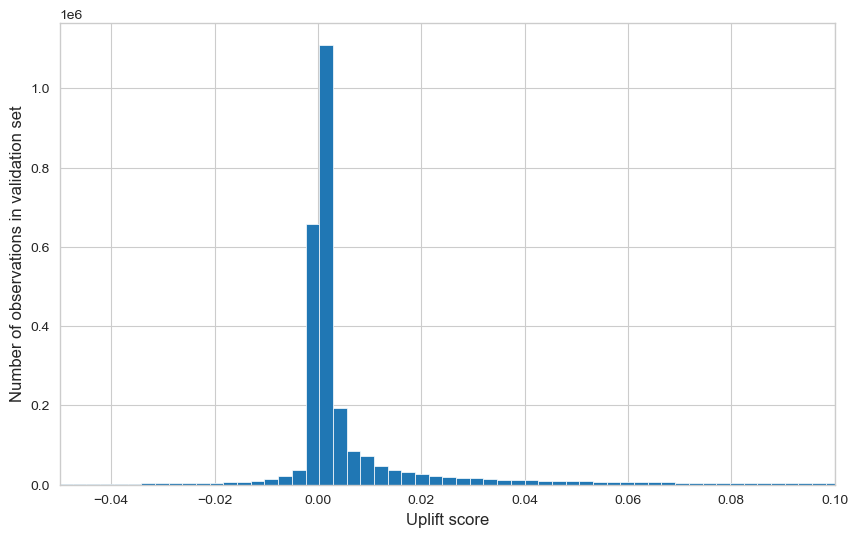

In [39]:
plt.figure(figsize = (10,6))
plt.xlim(-.05, .1)
plt.hist(result.uplift_score, bins=1000, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')
plt.savefig("figures/uplift_score.png", dpi=150)
plt.show()

uplift 的分布 大部分 为正，这符合我们的分析结论：干预措施平均而言会促进用户访问。然而，部分样本的 uplift 为负，意味着该干预实际上会阻止某些用户访问（即“沉睡的狗”，sleeping dogs）。回顾我们之前的分析，这可能是因为这些用户未被有效曝光于干预之下，而我们已发现这种情况会降低点击率和转化率。

# Model evaluation

用于评估 uplift 的指标比监督学习中常用的指标（如 ROC AUC）更为复杂。这是因为对于同一个个体，我们无法同时观测到其在对照组和处理组下的结果，从而难以定义直接的损失函数。
一种衡量 uplift 的方法是使用 Qini 曲线（Radcliffe, 2007），它展示了随着被干预客户数量的增加，累积的增量正向结果（即 uplift）的变化情况。
一个性能更好的模型能够有效区分具有正向响应和负向响应的个体，从而使 Qini 曲线与代表随机干预策略的对角线之间产生更大的分离。

In [44]:
def qini_rank(uplift): 
    # 用于根据 uplift 分数对数据进行排序
    ranked = pd.DataFrame({'ranked uplift':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['ranked uplift'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='ranked uplift').reset_index(drop=True)
    return ranked

def qini_eval(ranked):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # 使用处理组和对照组计算 uplift（增量收益）
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # 计算 uplift 和随机值，并将其存入 DataFrame
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['ranked uplift'] * uplift_model['uplift'].iloc[-1],5)
    
    uplift_model['Number_of_exposed_customers'] = np.arange(len(uplift_model))+1
    uplift_model['visits_gained'] = uplift_model.uplift*len(uplift_model)
    
    # 添加q0
    q0 = pd.DataFrame({'ranked uplift':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # 添加模型名称
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='ranked uplift').reset_index(drop = True)
    return merged, uplift_model

def uplift_curve(uplift_model):
    plt.figure(figsize = (10,6))
    #绘制数据
    ax = uplift_model['visits_gained'].plot(color=['#2077B4'])
    #绘制设置
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Number of customers treated')
    plt.ylabel('Incremental visits')
    plt.grid(visible=True, which='major')
    return ax

def qini_plot(merged:pd.DataFrame, uplift_model:pd.DataFrame):
    gain_x = uplift_model['ranked uplift']
    gain_y = uplift_model.uplift
    qini = auc(gain_x, gain_y)
    # plot the data
    plt.figure(figsize = (10,6))
    mpl.rcParams['font.size'] = 8
    qini = auc(gain_x, gain_y)

    ax = plt.plot(gain_x, gain_y, color= '#2077B4',
        label='Normalized Uplift Model, Qini Score: {}'.format(round(qini,2)))
    
    plt.plot([0, gain_x.max()], [0, gain_y.max()],
        '--', color='tab:orange',
        label='Random Treatment')
    plt.legend()
    plt.xlabel('Porportion Targeted')
    plt.ylabel('Uplift')
    plt.grid(visible=True, which='major')

    return ax

def plot_uplift(result:pd.DataFrame):
    #uplift 曲线
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax1 = uplift_curve(uplift_model)
    
    return ax1

def plot_qini(result:pd.DataFrame):
    #qini曲线
    ranked = qini_rank(result)
    merged, uplift_model = qini_eval(ranked)
    ax2 = qini_plot(merged, uplift_model)
    
    return ax2 

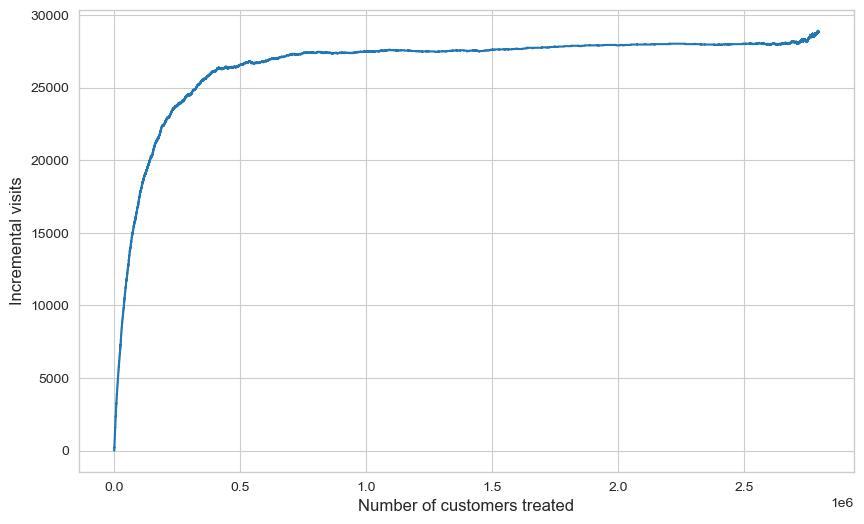

In [46]:
plot_uplift(result)
plt.show()

如果我们向所有客户（250万）提供干预，访客数量将增加 3 万人。
然而，仅对前 20% 的客户（即 top 20%）提供干预，我们就能获得 2.6 万名新增客户，约为最大可能收益的 86%。

不过，uplift 曲线的一个优势在于：与 ROC 曲线类似，我们可以计算其曲线下面积（AUC）。面积越大，说明模型性能越好——我们希望用尽可能少的目标客户，获得尽可能多的新增客户。

但在计算 AUC 之前，最好先对数据进行归一化。如图所示，当前增益曲线的横轴和纵轴都以“客户数量”为单位，这虽然便于用实际业务量进行可视化，却使得不同模型之间的比较变得非常困难。
我们可以通过缩放曲线，使横纵坐标均归一化到 0 到 1 之间，从而解决这一问题。

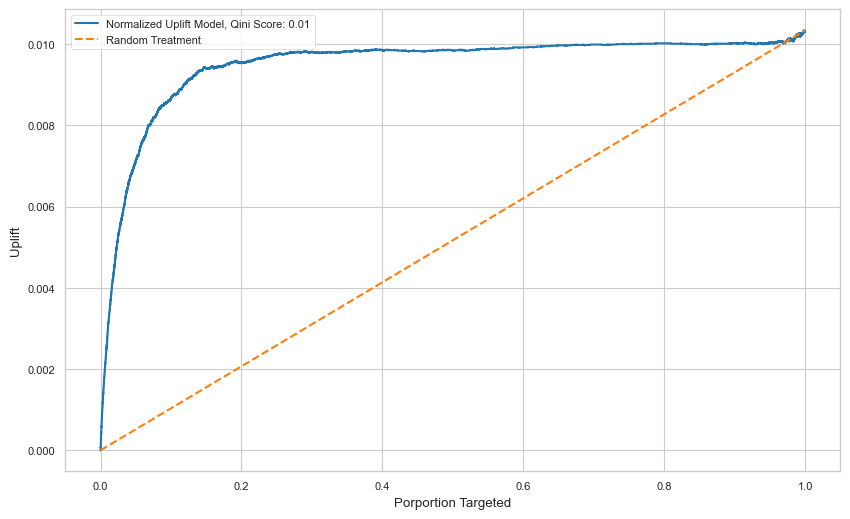

In [47]:
plot_qini(result)
plt.show()

尽管该模型似乎能够区分正向与负向结果（如其初始陡峭的斜率所示），但其 Qini 分数仅为 0.01，表明该干预带来的总增量正向结果很低，实际上与随机干预策略几乎没有差别。

值得进一步考虑的是：用户是否被有效曝光对其增量结果有何影响。这将通过调用上文定义的函数，并将处理类别从 'treatment' 改为 'exposure' 来进行探索。

Class 0: 13551380
Class 1: 428212
Proportion: 32 : 1


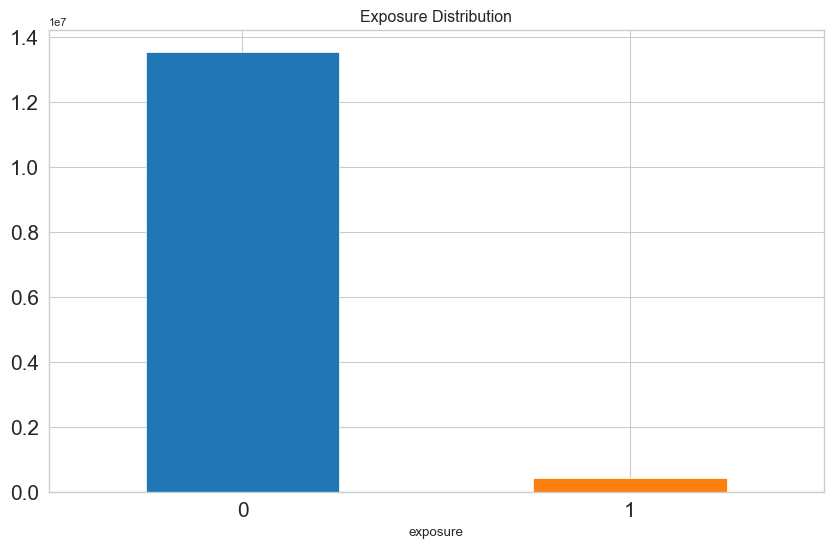

In [48]:
plt.figure(figsize = (10,6))
target_count = df['exposure'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[0] / target_count[1])), ': 1')
target_count.plot(kind='bar', title='Exposure Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

与之前的例子非常相似，处理类别（treatment class）存在严重的不平衡，大约每 32 名用户中仅有 1 人被有效曝光于干预。

In [49]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df['exposure'])

In [50]:
train = random_under(train, 'exposure')

Class 0: 342570
Class 1: 342570
Proportion: 1 : 1


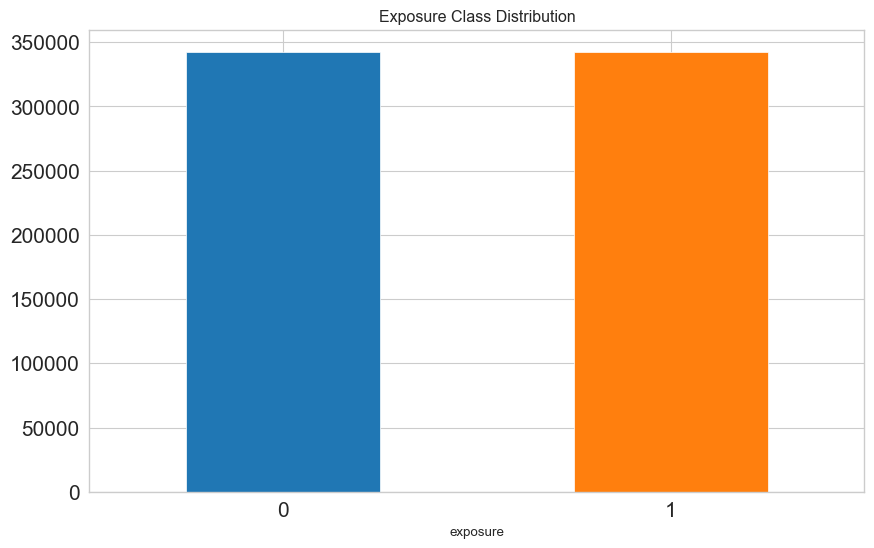

In [51]:
plt.figure(figsize = (10,6))
new_target_count = train['exposure'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Exposure Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 
plt.show()

In [52]:
train = target_class(train.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')
test = target_class(test.drop(columns = ['conversion', 'treatment']), 'exposure', 'visit')

In [53]:
X_train = train.drop(['visit','target_class'],axis=1)
y_train = train['target_class']
X_test = test.drop(['visit','target_class'],axis=1)
y_test = test['target_class']

In [54]:
result = uplift_model(X_train, X_test, y_train, y_test, 'exposure')

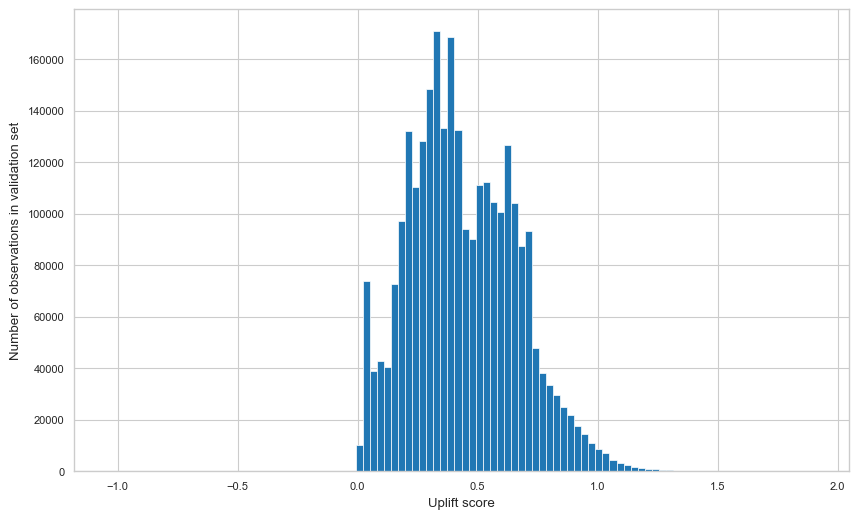

In [55]:
plt.figure(figsize = (10,6))
plt.hist(result.uplift_score, bins=100, color=['#2077B4'])
plt.xlabel('Uplift score')
plt.ylabel('Number of observations in validation set')
plt.show()

uplift 的分布几乎全部为正，这意味着当用户被有效曝光时，干预几乎总是鼓励他们进行访问，而几乎从不会产生抑制作用。

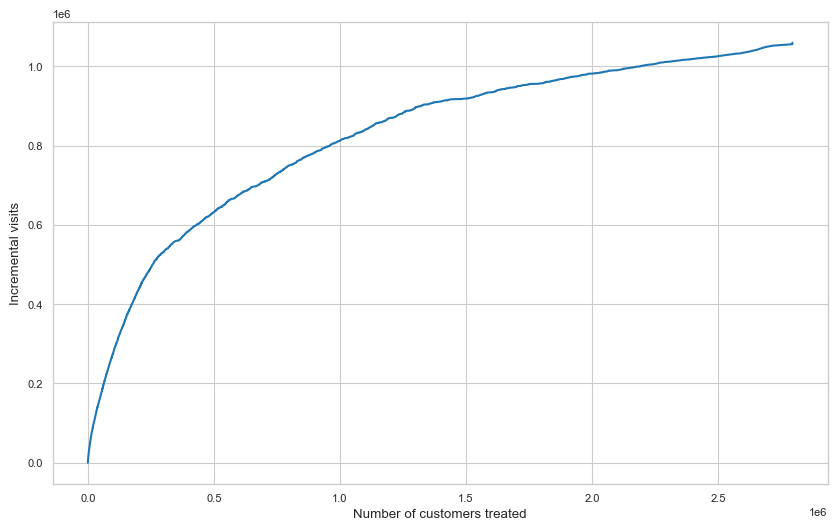

In [56]:
plot_uplift(result)
plt.show()

如图所示，当用户被有效曝光于干预时，其带来的增量正向结果（即 uplift）要高得多。
如果我们向所有客户都提供干预，访客数量将增加 1,060,000 人。
然而，仅对前 20% 的客户（即 top 20%）提供干预，我们就能获得 620,000 名新增客户，约为最大可能收益的 58%。

鉴于客户规模存在显著差异，为了将该模型与之前的模型进行比较，我们必须再次对结果进行归一化处理。

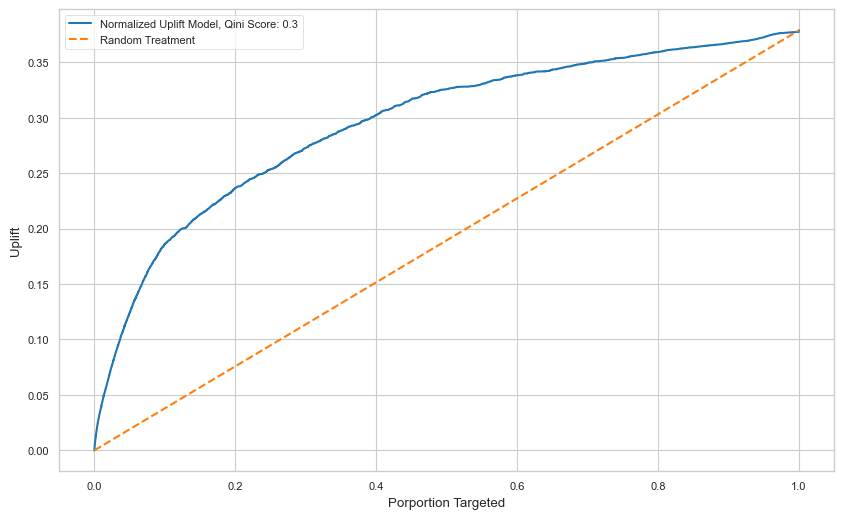

In [57]:
plot_qini(result)
plt.show()

如图所示，该模型的 Qini 分数比之前的模型高出约 29 倍，表明在用户被有效曝光的前提下，其累积的增量正向结果要大得多。

# Conclusion

uplift 建模的目标是构建个体处理效应（Individual Treatment Effect）的预测模型。这类模型使数据科学家能够将人群划分为更可能对干预产生响应的群体和较不可能响应的群体。在本例中，与普通处理组相比，确保用户被有效曝光于干预措施能显著提升增量结果。

可以看出，uplift 模型的评估不像监督学习中的分类或回归模型那样直接，因为它需要分别考虑并比较处理组和对照组。不过，目前已有一些开源的 Python 工具包（如 [CausalML](https://causalml.readthedocs.io/en/latest/)、[Pylift](https://pylift.readthedocs.io/) 和 [Scikit-Uplift](https://scikit-uplift.readthedocs.io/en/latest/)）被开发出来，以支持 uplift 模型的构建与评估。